# Test Checkpoint Loading

This notebook tests loading a trained model from checkpoint and running inference on the validation set.


In [1]:
# Imports
import os
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from src.mamba.train_functions import collate_fn, get_predictions
import matplotlib.pyplot as plt

# Add parent directory to path to import mamba_model
notebook_dir = Path.cwd()
if 'cv_training' in str(notebook_dir):
    mamba_dir = notebook_dir.parent
else:
    mamba_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd() / 'src' / 'mamba'

sys.path.insert(0, str(mamba_dir))
from src.mamba.mamba_model import TrajectoryMambaModel, ModelArgs
from src.mamba.trajectory_dataloader import TrajectoryDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%load_ext autoreload
%autoreload 2


Using device: cuda


In [2]:
# Configuration - must match training configuration
notebook_path = Path.cwd()
if 'cv_training' in str(notebook_path):
    data_dir = notebook_path / 'data' / 'data'
    checkpoint_dir = notebook_path / 'checkpoints'
else:
    data_dir = Path('cv_training/data/data')
    checkpoint_dir = Path('cv_training/checkpoints')

config = {
    # Data
    'data_dir': str(data_dir),
    'train_split': 0.8,
    'val_split': 0.2,
    
    # Data Dimensions
    'input_dim': 2,
    'num_classes': 3,
    
    # Model "Brain" Dimensions - must match training
    'd_model': 64,
    'n_layer': 4,
    'd_state': 16,
    'expand': 2,
    
    # DataLoader
    'batch_size': 32,
    'min_seq_length': 2,
    'num_workers': 0,
    'seed': 42
}

# Set random seed
torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")


Configuration:
  data_dir: cv_training\data\data
  train_split: 0.8
  val_split: 0.2
  input_dim: 2
  num_classes: 3
  d_model: 64
  n_layer: 4
  d_state: 16
  expand: 2
  batch_size: 32
  min_seq_length: 2
  num_workers: 0
  seed: 42


In [3]:
# Load dataset and create validation loader
data_path = Path(config['data_dir'])
if not data_path.exists():
    raise ValueError(f"Data directory not found: {data_path}")

dataset = TrajectoryDataset(str(data_path))
print(f"Total trajectories: {len(dataset)}")

# Split into train and validation (same split as training)
train_size = int(config['train_split'] * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], 
                                         generator=torch.Generator().manual_seed(config['seed']))

print(f"Train trajectories: {len(train_dataset)}")
print(f"Validation trajectories: {len(val_dataset)}")

# Create validation dataloader
val_loader = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    collate_fn=collate_fn
)


Total trajectories: 16000
Train trajectories: 12800
Validation trajectories: 3200


In [4]:
# Create model with same architecture as training
model_args = ModelArgs(
    d_model=config['d_model'],
    n_layer=config['n_layer'],
    d_state=config['d_state'],
    expand=config['expand']
)

model = TrajectoryMambaModel(model_args, input_dim=config["input_dim"]).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")


Model created with 126594 parameters


In [5]:
# Load checkpoint
checkpoint_path = checkpoint_dir / 'checkpoint_epoch_25.pt'
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model state dict
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Model loaded successfully!")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Train Loss: {checkpoint.get('train_loss', 'N/A'):.6f}")
print(f"  Val Loss: {checkpoint.get('val_loss', 'N/A'):.6f}")

# Set model to evaluation mode
model.eval()


Loading checkpoint from: cv_training\checkpoints\checkpoint_epoch_25.pt
✓ Model loaded successfully!
  Epoch: 24
  Train Loss: 0.002397
  Val Loss: 0.002197


TrajectoryMambaModel(
  (encoder): Linear(in_features=2, out_features=64, bias=True)
  (backbone): Mamba(
    (layers): ModuleList(
      (0-3): 4 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=64, out_features=256, bias=False)
          (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
          (x_proj): Linear(in_features=128, out_features=32, bias=False)
          (out_proj): Linear(in_features=128, out_features=64, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (norm_f): RMSNorm()
  )
  (pred_head): Linear(in_features=64, out_features=2, bias=True)
)

In [6]:
# Run inference on validation set
results = get_predictions(model, val_loader, device)
print(f"\n✓ Inference completed!")
print(f"  Total trajectories: {len(results['preds'])}")


Generating predictions...
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got to the collate
Got t

Global RMSE in Real Units: 0.9424


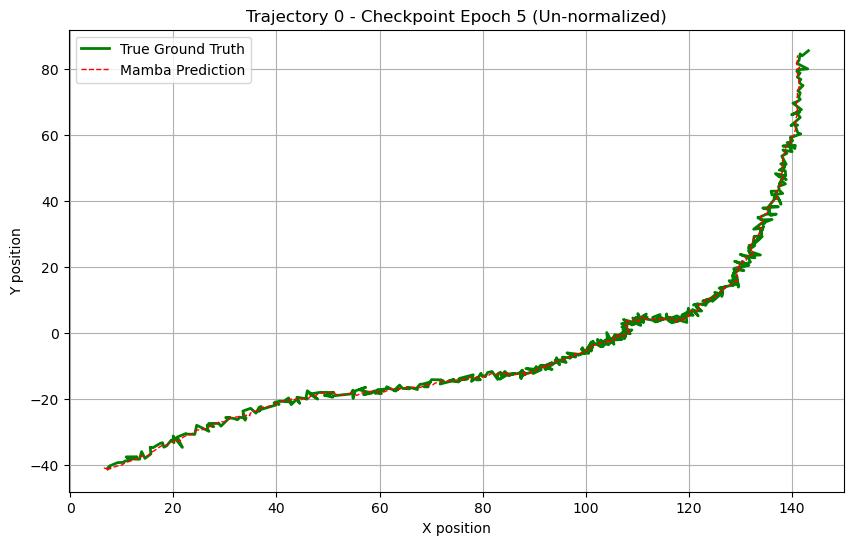


✓ Plot generated successfully!
  This confirms that checkpoint loading works correctly.


In [7]:
# Plot one trajectory and prediction (same as in train_mamba.ipynb)
idx = 0  # Plot first trajectory

pred_traj = results["preds"][idx]
true_traj = results["targets"][idx]
kf_data = results["kf_params"][idx]
real_positions = results["real_positions"][idx][1:]  # to match the dimensions of other measurements

# Calculate RMSE
all_preds_concat = np.concatenate([pred_traj], axis=0) if isinstance(pred_traj, list) else pred_traj
all_targets_concat = np.concatenate([true_traj], axis=0) if isinstance(true_traj, list) else true_traj

rmse = np.sqrt(np.mean((all_preds_concat - all_targets_concat)**2))
print(f"Global RMSE in Real Units: {rmse:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(true_traj[:, 0], true_traj[:, 1], 'g-', label='True Ground Truth', linewidth=2)
plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', label='Mamba Prediction', linewidth=1)
plt.title(f"Trajectory {idx} - Checkpoint Epoch 5 (Un-normalized)")
plt.legend()
plt.grid(True)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

print(f"\n✓ Plot generated successfully!")
print(f"  This confirms that checkpoint loading works correctly.")


In [17]:

# 2. Visualize the first trajectory in the validation set
import matplotlib.pyplot as plt
idx = 20

# Now you can access everything safely by index
pred_traj = results["preds"][idx]
true_traj = results["targets"][idx]
kf_data = results["kf_params"][idx]
real_positions = results["real_positions"][idx][1:] #to match the dimensions of other measurements


# 3. Calculate Real RMSE (Meters)
# Concatenate all to calculate global error
import numpy as np
all_preds_concat = np.concatenate(pred_traj, axis=0)
all_targets_concat = np.concatenate(true_traj, axis=0)

rmse = np.sqrt(np.mean((all_preds_concat - all_targets_concat)**2))
print(f"Global RMSE in Real Units: {rmse:.4f}")

Global RMSE in Real Units: 0.9879


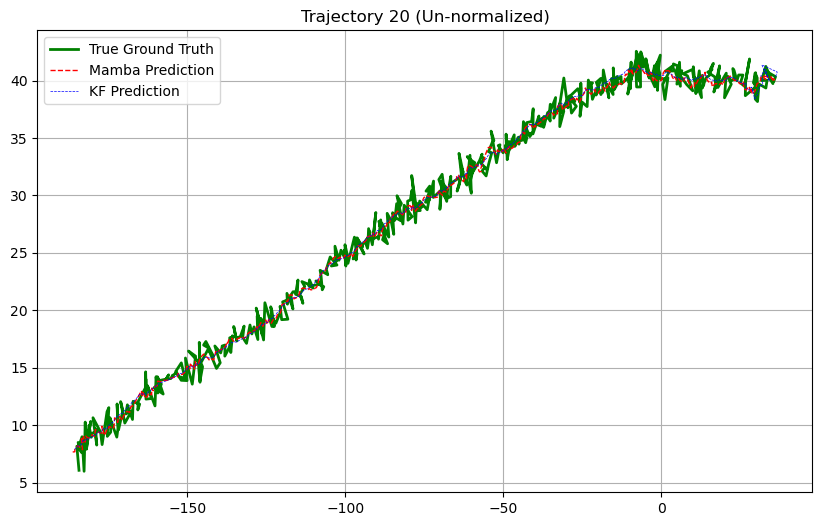

KF MSE: 0.05507432892773053
Mamba MSE: 0.19555582106113434


In [18]:
from src.filters.cv_kalman_filter import CVKalmanFilter, InitializationData
from src.motion_models.trajectory_generation.route_generation import TrajectoryState, generate_cv_trajectory

measurement_noise_std = kf_data["measurement_noise_std"]
vel_change_std = kf_data["vel_change_std"]
NOISE = np.array([measurement_noise_std,measurement_noise_std])
PROCESS_NOISE_STD = np.array([vel_change_std,vel_change_std])
dt=0.04

# Initialzing the KF
initial_matrices_data = InitializationData(observation_noise_std=NOISE, process_noise_std=PROCESS_NOISE_STD)

base_kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)
base_kf.initialize()

mse_k1, preds_k1= base_kf.evaluate_on_trajectory(
    true_traj,
    normalize_mse=False,
    return_predictions=True)


plt.figure(figsize=(10, 6))
plt.plot(true_traj[:, 0], true_traj[:, 1], 'g-', label='True Ground Truth', linewidth=2)
plt.plot(pred_traj[:, 0], pred_traj[:, 1], 'r--', label='Mamba Prediction', linewidth=1)
plt.plot(preds_k1[:, 0], preds_k1[:, 1], 'b--', label='KF Prediction', linewidth=0.5)
#plt.plot(real_positions[1:, 0], real_positions[1:, 1], 'y--', label='Real Position', linewidth=1.5)
plt.title(f"Trajectory {idx} (Un-normalized)")
plt.legend()
plt.grid(True)
plt.show()

kf_mse = np.mean((preds_k1[100:] - real_positions[101:])**2)
print(f"KF MSE: {kf_mse}")
mamba_mse = np.mean((pred_traj[100:] - real_positions[100:])**2)
print(f"Mamba MSE: {mamba_mse}")

In [10]:
# After your comparison cell, add this diagnostic:

# Compare across multiple trajectories
n_check = 50  # Check first 50 trajectories
mamba_wins = []
kf_wins = []
mamba_margins = []
kf_margins = []

for i in range(len(results["preds"])):
    pred_traj = results["preds"][i]
    true_traj = results["targets"][i]
    kf_data = results["kf_params"][i]
    clean_targets = results["real_positions"][i][1:]
    
    # Run KF
    measurement_noise_std = kf_data["measurement_noise_std"]
    vel_change_std = kf_data["vel_change_std"]
    NOISE = np.array([measurement_noise_std,measurement_noise_std])
    PROCESS_NOISE_STD = np.array([vel_change_std,vel_change_std])
    dt=0.04
    
    # Initialzing the KF
    initial_matrices_data = InitializationData(observation_noise_std=NOISE, process_noise_std=PROCESS_NOISE_STD)
    
    base_kf = CVKalmanFilter(2, 4, 2, dt, initial_matrices_data)
    base_kf.initialize()
    
    mse_k1, preds_k1= base_kf.evaluate_on_trajectory(
        true_traj,
        normalize_mse=False,
        return_predictions=True)
        
    # Compare to clean ground truth
    mamba_mse = np.mean((pred_traj - clean_targets)**2)
    kf_mse = np.mean((preds_k1 - clean_targets[1:])**2)
    
    margin = (kf_mse - mamba_mse) / kf_mse * 100  # % improvement of Mamba over KF
        
    if mamba_mse < kf_mse:
        mamba_wins.append(i)
        mamba_margins.append(margin)
    else:
        kf_wins.append(i)
        kf_margins.append(-margin)

print(f"\n=== Analysis of {n_check} trajectories ===")
print(f"Mamba wins: {len(mamba_wins)} ({len(mamba_wins)/n_check*100:.1f}%)")
print(f"KF wins: {len(kf_wins)} ({len(kf_wins)/n_check*100:.1f}%)")
if mamba_margins:
    print(f"Mamba average improvement when winning: {np.mean(mamba_margins):.2f}%")
    print(f"Mamba max improvement: {np.max(mamba_margins):.2f}%")
if kf_margins:
    print(f"KF average improvement when winning: {np.mean(kf_margins):.2f}%")

# Check if there's a pattern in the winning trajectories
if mamba_wins:
    print(f"\nTrajectories where Mamba wins: {mamba_wins[:10]}...")
    # Check if they share characteristics (e.g., same noise levels, short trajectories, etc.)


=== Analysis of 50 trajectories ===
Mamba wins: 37 (74.0%)
KF wins: 3163 (6326.0%)
Mamba average improvement when winning: 7.41%
Mamba max improvement: 39.62%
KF average improvement when winning: 1988.23%

Trajectories where Mamba wins: [38, 117, 218, 535, 607, 677, 701, 791, 795, 850]...
